In [ ]:
!pip install vit_pytorch
!pip install tensorflow_addons

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 6.8 MB/s 


## Import package

In [ ]:
import numpy as np 
import pandas as pd
import math 
from tqdm.notebook import tqdm, trange
import time
import os
import scipy
import matplotlib.pyplot as plt
import torch
from keras.models import load_model
from vit_pytorch import ViT
import tensorflow as tf
from random import shuffle
from tensorflow import keras
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage.interpolation import shift
from PIL import Image, ImageFilter
import cv2
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
from keras.utils.vis_utils import plot_model

## Import data

In [ ]:
# root_path = "/content/gdrive/MyDrive/Colab Notebooks/CS5487/Data/" # path where we put data
root_path = "https://raw.githubusercontent.com/William-WANG2/CS5487-CityU/master/dataset/"
label_url = os.path.join(root_path, "digits4000_digits_labels.txt")
data_url = os.path.join(root_path, "digits4000_digits_vec.txt")
train_index_url = os.path.join(root_path, "digits4000_trainset.txt")
test_index_url = os.path.join(root_path, "digits4000_testset.txt")

In [ ]:
label = pd.read_csv(label_url, sep = ' ', header = None)
label.columns = ['label']
data = pd.read_csv(data_url, sep = '\t', header = None)
# data = data.T
train_index = pd.read_csv(train_index_url, sep = '\t', header = None)
test_index = pd.read_csv(test_index_url, sep = '\t', header = None)



In [ ]:
print(label.shape)
# print(data)
# print(train_index)
# print(test_index)

(4000, 1)


In [ ]:
trial_num = 1# {1, 2} try two independent trials 

In [ ]:
trial_train_index = train_index.loc[:, trial_num - 1] - 1
trial_test_index = test_index.loc[:, trial_num - 1] - 1
x_train = data.loc[trial_train_index , :]
x_test = data.loc[trial_test_index, :]
y_train = label.loc[trial_train_index]
y_test = label.loc[trial_test_index]

In [ ]:
# testing data
print(x_train.shape)
# print(x_train.describe())
print(x_test.shape)
# print(x_test.describe())
print(y_train.shape)

(2000, 784)
(2000, 784)
(2000, 1)


In [ ]:
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


Before shuffling:
After shuffling


(-0.5, 27.5, 27.5, -0.5)

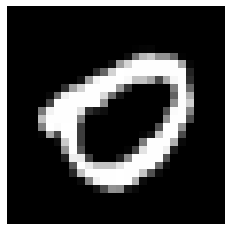

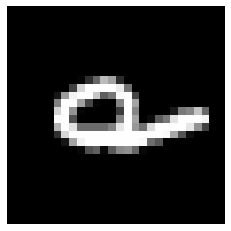

In [ ]:
print("Before shuffling:")
plt.figure(figsize=(4, 4))
image = x_train.iloc[0]
image = image.values.reshape(28, 28, 1)
plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
plt.axis("off")

# Shuffle data
x_train['label'] = y_train
x_train = x_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = x_train['label']
x_train.drop(columns = ['label'], inplace = True)

print("After shuffling")
plt.figure(figsize=(4, 4))
image = x_train.iloc[0]
image = image.values.reshape(28, 28, 1)
plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
plt.axis("off")

#### Inspect on 5 random images 

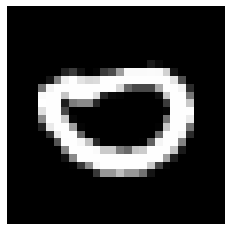

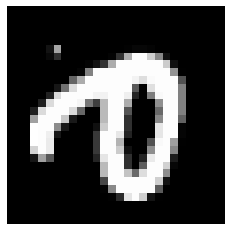

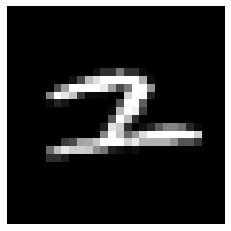

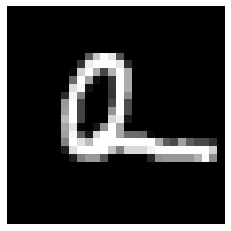

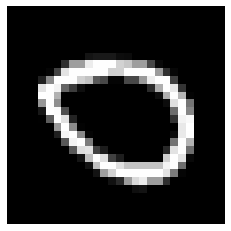

In [ ]:
for i in range(5):
  plt.figure(figsize=(4, 4))
  image = x_train.iloc[np.random.choice(range(x_train.shape[0]))]
  image = image.values.reshape(28, 28, 1)
  plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
  plt.axis("off")

### Encode the categorical target

In [ ]:
num_classes = 10
y_train_label = y_train
y_test_label = y_test
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Data preprocessing

### Data Normalization and Augmentation

In [ ]:
# This preprossing section is for classical machine learning models only
# create new augmented dataset
x_train_aug = x_train.to_numpy()
x_train_aug = np.vstack((x_train_aug, np.zeros([3*x_train_aug.shape[0], x_train_aug.shape[1]])))
y_train_label_aug = y_train_label.to_numpy()
y_train_label_aug = np.vstack((y_train_label.to_numpy().reshape([y_train_label_aug.shape[0], 1]), np.zeros([3*y_train_label_aug.shape[0], 1])))

#Zooming
# reshape to be [samples][width][height][channels]
tmp = x_train.to_numpy().reshape((x_train.shape[0], 28, 28, 1))
# convert from int to float
tmp = tmp.astype('float32')
# define data preparation
datagen = ImageDataGenerator(zoom_range=[0.7,1.0])
# fit parameters from data
datagen.fit(tmp)
idx = 2000
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(tmp, y_train_label, batch_size=2000):
  X_batch = X_batch.reshape((2000, 784))
  x_train_aug[idx:idx+2000, :] = X_batch
  y_train_label_aug[idx:idx+2000] = y_batch.reshape([2000,1])
  idx+=2000
  break

#Rotation
# reshape to be [samples][width][height][channels]
tmp = x_train.to_numpy().reshape((x_train.shape[0], 28, 28, 1))
# convert from int to float
tmp = tmp.astype('float32')
# define data preparation
datagen = ImageDataGenerator(rotation_range=20)
# fit parameters from data
datagen.fit(tmp)
idx = 2000
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(tmp, y_train_label, batch_size=2000):
  X_batch = X_batch.reshape((2000, 784))
  x_train_aug[idx:idx+2000, :] = X_batch
  y_train_label_aug[idx:idx+2000] = y_batch.reshape([2000,1])
  idx+=2000
  break

#Translation
# define data preparation
shift = 1
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(tmp)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(tmp, y_train_label, batch_size=2000):
  X_batch = X_batch.reshape((2000, 784))
  x_train_aug[idx:idx+2000, :] = X_batch
  y_train_label_aug[idx:idx+2000] = y_batch.reshape([2000,1])
  idx+=2000
  break


In [ ]:
# # Data normalization
# x_train /= 255.0
# x_test /= 255.0

IMG_SIZE = 36
resize = keras.Sequential(
    [
    layers.Resizing(IMG_SIZE, IMG_SIZE), # Effect of resize : https://keras.io/examples/vision/learnable_resizer/
    ]
)

In [ ]:
# Not used in training. Use ImageDataGenerator instead 
# https://www.tensorflow.org/tutorials/images/data_augmentation 


data_augmentation = keras.Sequential(
    [
        # layers.Normalization(), 
        # layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1), # minor improvement, 0.86 -> 0.88(only for dataset 1)
        layers.experimental.preprocessing.RandomTranslation(height_factor = 0.1, 
                                                            width_factor = 0.1,
                                                            interpolation = 'nearest')
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2 # Minor improvement for dataset 0
        # ),

    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

  

In [ ]:
#normalization
x_train_aug = x_train_aug/255.0

###Extract feature from the data 

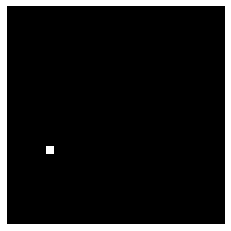

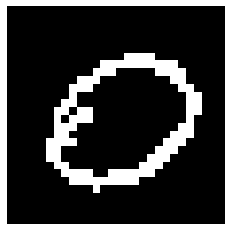

In [ ]:
extract_feature = "edge"
if extract_feature == "avg2":
  # We choose to average the 2*2 pixels' values of adjacent cells in image and assign it to a new one (resulting 14*14 images).
  x_train_aug_ori = x_train_aug
  x_train_aug = np.zeros([8000, 196])
  for num in range(8000):
    idx = 0
    for i in range(0, 28, 2):
      for j in range(0, 28, 2):
        x_train_aug[num, idx] = (x_train_aug_ori[num, i*28+j]+x_train_aug_ori[num, i*28+j+1]+x_train_aug_ori[num, (i+1)*28+j]+x_train_aug_ori[num, (i+1)*28+j+1])/4
        idx += 1
  x_test_ori = x_test.to_numpy()
  x_test = np.zeros([2000, 196])
  for num in range(2000):
    idx = 0
    for i in range(0, 28, 2):
      for j in range(0, 28, 2):
        x_test[num, idx] = (x_test_ori[num, i*28+j]+x_test_ori[num, i*28+j+1]+x_test_ori[num, (i+1)*28+j]+x_test_ori[num, (i+1)*28+j+1])/4
        idx += 1
  #plot first one:
  plt.figure(figsize=(4, 4))
  image = tmp.reshape([x_train_aug.shape[0], 14, 14, 1])[10, :, :, :]
  plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
  plt.axis("off")
elif extract_feature == "edge":
  #We will convolve the images to get its edge information
  #reshape to be [samples][width][height][channels]
  tmp = x_train_aug.reshape((x_train_aug.shape[0], 28, 28))
  for i in range(8000):
    img = tmp[i,:,:]
    img = Image.fromarray((img * 255).astype('uint8'), mode='L')
    # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
    # May also consider SMOOTH, SHARPEN, 
    img = img.filter(ImageFilter.FIND_EDGES)
    tmp[i,:,:] = np.array(img)/255
  #plot first one:
  plt.figure(figsize=(4, 4))
  image = tmp.reshape([x_train_aug.shape[0], 28, 28, 1])[10, :, :, :]
  plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
  plt.axis("off")

  x_train_aug = tmp.reshape((8000, 784))

  #test set feature extraction
  tmp = x_test.to_numpy().reshape((x_test.shape[0], 28, 28))
  for i in range(2000):
    img = tmp[i,:,:]
    img = Image.fromarray((img).astype('uint8'), mode='L')
    # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
    # May also consider SMOOTH, SHARPEN, 
    img = img.filter(ImageFilter.FIND_EDGES)
    tmp[i,:,:] = np.array(img)
  x_test = tmp.reshape((2000, 784))
    

###Dimensionality Reduction



PCA

In [ ]:
#see documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca_digits=PCA(n_components=150) 
x_train_aug_pca = pca_digits.fit_transform(x_train_aug) 
plt.plot(pca_digits.explained_variance_ratio_)
plt.xlabel("# of Principle Components")
plt.ylabel("Explaned Variance")
plt.show()

Hence, from the figure, we will choose the first 40 principle components as it gives the sudden change of rate.

If we use the average of 4 features, we use first 40 principle components

If we use edge information, we use first 60 principle components.

In [ ]:
pca_digits=PCA(40) 
x_train_aug_pca = pca_digits.fit_transform(x_train_aug) 
if extract_feature == "edge":
  pca_digits=PCA(60) 
  x_train_aug_pca = pca_digits.fit_transform(x_train_aug) 

In [ ]:
#PCA first 10 principle vectors visualization
#Setup a figure 8 inches by 8 inches 
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the digits, each image is 64 by 64 pixels 
for i in range(20): 
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
  ax.imshow(np.reshape(pca_digits.components_[i,:], (np.sqrt(x_train_aug.shape[1]).astype(int),np.sqrt(x_train_aug.shape[1]).astype(int))), cmap=plt.cm.bone, interpolation='nearest') 

kPCA

In [ ]:
#kpca
kpca_digits = KernelPCA(n_components=150, kernel="poly", degree=4)
x_train_aug_kpca = kpca_digits.fit_transform(x_train_aug) 
plt.plot(kpca_digits.eigenvalues_)
plt.xlabel("# of Principle Components")
plt.ylabel("Eigenvalues")
plt.show()

Hence, still, from the figure, we will choose the first 40 principle components as it gives the sudden change of rate.
If we use the average of 4 features, we use first 40 principle components.
If we use edge information, we use first 60 principle components.

In [ ]:
kpca_digits = KernelPCA(n_components=40, kernel="poly", degree=4)
x_train_aug_kpca = kpca_digits.fit_transform(x_train_aug) 
if extract_feature == "edge":
  kpca_digits = KernelPCA(n_components=60, kernel="poly", degree=4)
  x_train_aug_kpca = kpca_digits.fit_transform(x_train_aug) 

LDA

Since the number of features k = 784 >> C = 10, we adopt the largest number of components after LDA, i.e. C-1 = 9 which is also the default setting in [scikit learn package](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html). 

In [ ]:
lda_digits = LinearDiscriminantAnalysis()
x_train_aug_lda = lda_digits.fit_transform(x_train_aug, np.ravel(y_train_label_aug))

##Model

In [ ]:
model_name= "MLP" # "MLP", "SVM", "Logit", "NaiveBayes", "CNN", "ViT", "ViT_SPT"

We first define some functions to be used in training the classic machine learning models, i.e. SVM, Naive Bayes, Logistic Regression.

In [ ]:
#Cross-Validation for regularizition Parameter C tunning
def plot_cv_acc(model, x, y, title):
  #Cross-Validation for C 
  acc = []
  for c in [0.01,0.1,1,10,100]:
      model.set_params(C = c)
      #cross-validation
      scores = cross_val_score(model, x, np.ravel(y), cv=5)
      acc.append(scores)

  c = [0.01,0.1,1,10,100]
  plt.subplots(figsize=(10, 5))
  plt.semilogx(c, acc,'-D')
  plt.grid(True)
  plt.xlabel("Regularization parameter C")
  plt.ylabel("Accuracy")
  plt.legend(["#1 splitting", "#2 splitting", "#3 splitting", "#4 splitting", "#5 splitting"])
  plt.title(title)
  plt.show()

#Training and Testing for SVM and Logistic Regression
def evaluate1(model, trainx, trainy, testx, testy, c, name):
  print("### Start Training")
  model.set_params(C = c)
  model.fit(trainx, np.ravel(trainy))
  print("======================================")
  print("### Test Result (%s): ", name)
  pred = model.predict(testx)
  print(accuracy_score(pred, np.ravel(testy)))
  cm = confusion_matrix(testy, pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()

#Training and Testing for Naive Bayes
def evaluate2(model, trainx, trainy, testx, testy, name):
  print("### Start Training")
  model.fit(trainx, np.ravel(trainy))
  print("======================================")
  print("### Test Result (%s): ", name)
  pred = model.predict(testx)
  print(accuracy_score(pred, np.ravel(testy)))
  cm = confusion_matrix(testy, pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()

### Multi-Layer Perceptron

Result:
0.94 on trial 1 <br/>
0.9335 on trial 2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Start Training
### Test Result: 
63/63 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9440


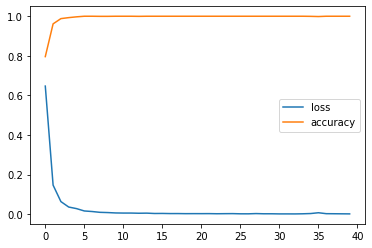

In [ ]:
if model_name == "MLP":
    keras.backend.clear_session() # clear previous cache
    model = keras.models.Sequential([
        # keras.layers.InputLayer(input_shape=(784, 1)),
        keras.layers.Rescaling(1/255.0),                              
        keras.layers.Dense(512, use_bias = True, 
                            activation = 'relu'
        ), # how to set the dense layer size 
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, use_bias = True,
                            activation = 'relu'
                            ),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(100, use_bias = True, 
                            activation = 'relu'
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='softmax')
    ])

    # model = keras.models.Sequential()
    # model.add(Dense(units=512, activation='relu', input_shape=(784,)))
    # model.add(Dense(units = 512, activation='relu'))
    # model.add(Dense(units = 10, activation='softmax'))
    model.build(x_train.shape)
    # model.summary() 
    # Optimizer
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss="categorical_crossentropy"
    , optimizer=sgd
    , metrics=["accuracy"])
    # plot_model(model, to_file='custom-mlp.png', show_shapes=True, show_layer_names=False)

    print("### Start Training")
    history = model.fit(x_train, y_train, epochs = 40, verbose = 0)
    pd.DataFrame(history.history).plot()
    print("======================================")
    print("### Test Result: ")
    model.evaluate(x_test, y_test)    

###SVM

**Result**: <br/>


1.   SVM+PCA

*   trial 1: 0.8755
*   trial 2: 0.72
*   challenge: 0.5867

2.   kSVM+PCA

*   trial 1: 0.9565
*   trial 2: 0.978
*   challenge: 0.7667
3.   SVM+kPCA
*   trial 1: 0.8865
*   trial 2: 0.786
*   challenge: 0.6
4.   kSVM+kPCA
*   trial 1: 0.954
*   trial 2: 0.974
*   challenge: 0.7667
5.   SVM+LDA
*   trial 1: 0.8055
*   trial 2: 0.8575
*   challenge: 0.507
6.   kSVM+LDA
*   trial 1: 0.8155
*   trial 2: 0.9595
*   challenge: 0.527


Hyper-Parameter Tuning



In [ ]:
#Cross-Validation for hyper-para C
if model_name == "SVM":

  lsvm = LinearSVC(fit_intercept=True, dual = False)
  ksvm = SVC(kernel='rbf')
  #Cross-Validation for C in SVM and kSVM
  plot_cv_acc(lsvm, x_train_aug, y_train_label_aug, 'Accuracy versus the Regularization parameter C (SVM)')
  plot_cv_acc(ksvm, x_train_aug, y_train_label_aug, 'Accuracy versus the Regularization parameter C (kSVM)')
  #Cross-Validation for C in SVM + PCA
  plot_cv_acc(lsvm, x_train_aug_pca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (SVM + PCA)')
  #Cross-Validation for C in kSVM + PCA
  plot_cv_acc(ksvm, x_train_aug_pca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (kSVM + PCA)')
  #Cross-Validation for C in SVM + kPCA
  plot_cv_acc(lsvm, x_train_aug_kpca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (SVM + kPCA)')
  #Cross-Validation for C in kSVM + kPCA
  plot_cv_acc(ksvm, x_train_aug_kpca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (kSVM + kPCA)')
  #Cross-Validation for C in SVM + LDA
  plot_cv_acc(lsvm, x_train_aug_lda, y_train_label_aug, 'Accuracy versus the Regularization parameter C (SVM + LDA)')
  #Cross-Validation for C in kSVM + LDA
  plot_cv_acc(ksvm, x_train_aug_lda, y_train_label_aug, 'Accuracy versus the Regularization parameter C (kSVM + LDA)')


From the above 6 figures, we conclude that for all 4 combinations given by (PCA, kPCA, LDA) * (SVM, kSVM), we adopt 

---
C = 1, except for LDA, we adopt C = 0.1

Training and Testing

In [ ]:
#Normolization Test Set
if model_name == "SVM":
  x_test = x_test/255

In [ ]:
if model_name == "SVM":
  #Train and Testing
  lsvm = LinearSVC(fit_intercept=True, dual = False)
  ksvm = SVC(kernel='rbf')
  lsvm_pca = LinearSVC(fit_intercept=True, dual = False)
  ksvm_pca = SVC(kernel='rbf')
  lsvm_kpca = LinearSVC(fit_intercept=True, dual = False)
  ksvm_kpca = SVC(kernel='rbf')
  lsvm_lda = LinearSVC(fit_intercept=True, dual = False)
  ksvm_lda = SVC(kernel='rbf')

  evaluate1(lsvm, x_train_aug, y_train_label_aug, x_test, y_test_label, 1, "SVM")
  evaluate1(ksvm, x_train_aug, y_train_label_aug, x_test, y_test_label, 1, "kSVM")
  #PCA
  evaluate1(lsvm_pca, x_train_aug_pca, y_train_label_aug, pca_digits.transform(x_test), y_test_label, 1, "PCA + SVM")
  evaluate1(ksvm_pca, x_train_aug_pca, y_train_label_aug, pca_digits.transform(x_test), y_test_label, 1, "PCA + kSVM")
  #kPCA
  evaluate1(lsvm_kpca, x_train_aug_kpca, y_train_label_aug, kpca_digits.transform(x_test), y_test_label, 1, "kPCA + SVM")
  evaluate1(ksvm_kpca, x_train_aug_kpca, y_train_label_aug, kpca_digits.transform(x_test), y_test_label, 1, "kPCA + kSVM")
  #LDA
  evaluate1(lsvm_lda, x_train_aug_lda, y_train_label_aug, lda_digits.transform(x_test), y_test_label, 1, "LDA + SVM")
  if extract_feature == "avg2":
    evaluate1(ksvm_lda, x_train_aug_lda, y_train_label_aug, lda_digits.transform(x_test), y_test_label, 10, "LDA + kSVM")
  else:
    evaluate1(ksvm_lda, x_train_aug_lda, y_train_label_aug, lda_digits.transform(x_test), y_test_label, 0.1, "LDA + kSVM")


###Logistic Regression

1.   Logistic Regression

*   trial 1: 0.8715
*   trial 2: 0.8705
*   challenge: 0.567

2.   Logistic Regression+PCA

*   trial 1: 0.8825
*   trial 2: 0.7385
*   challenge: 0.533
3.   Logistic Regression+kPCA
*   trial 1: 0.7595
*   trial 2: 0.519
*   challenge: 0.5533
4.   Logistic Regression+LDA
*   trial 1: 0.802
*   trial 2: 0.8765
*   challenge: 0.513

Hyper-Parameter Tuning

In [ ]:
if model_name == "Logit":
  #Cross-Validation for C in Logistic Regression
  logit = LogisticRegression(
      solver='liblinear',
      random_state = 42,
      penalty = 'l2')
  plot_cv_acc(logit, x_train_aug, y_train_label_aug, 'Accuracy versus the Regularization parameter C (Logistic Regression)')
  #CV for logit+PCA
  plot_cv_acc(logit, x_train_aug_pca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (Logistic Regression+PCA)')
  #CV for logit+kPCA
  plot_cv_acc(logit, x_train_aug_kpca, y_train_label_aug, 'Accuracy versus the Regularization parameter C (Logistic Regression+kPCA)')
  #CV for logit+LDA
  plot_cv_acc(logit, x_train_aug_lda, y_train_label_aug, 'Accuracy versus the Regularization parameter C (Logistic Regression+LDA)')

From the above 4 figures, we conclude that for all 4 combinations given by Logistic Regression and (nil, PCA, kPCA, LDA), we adopt 

---
C = 1, 1 and 0.1

In [ ]:
#Normalization
if model_name == "Logit":
  x_test = x_test/255

In [ ]:
if model_name == "Logit":
  #Train and Testing
  logit = LogisticRegression(
      solver='liblinear',
      penalty = 'l2')
  logit_pca = LogisticRegression(
      solver='liblinear',
      penalty = 'l2')
  logit_kpca = LogisticRegression(
      solver='liblinear',
      penalty = 'l2')
  logit_lda = LogisticRegression(
      solver='liblinear',
      penalty = 'l2')
  evaluate1(logit, x_train_aug, y_train_label_aug, x_test, y_test_label, 1, "Logistic Regression")
  #PCA
  evaluate1(logit_pca, x_train_aug_pca, y_train_label_aug, pca_digits.transform(x_test), y_test_label, 1, "Logistic Regression+PCA")
  #kPCA
  evaluate1(logit_kpca, x_train_aug_kpca, y_train_label_aug, kpca_digits.transform(x_test), y_test_label, 0.1, "Logistic Regresion+kPCA")
  #LDA
  evaluate1(logit_lda, x_train_aug_lda, y_train_label_aug, lda_digits.transform(x_test), y_test_label, 0.1, "Logistic Regresion+LDA")


###Naive Bayes

1.  Naive Bayes

*   trial 1: 0.5465
*   trial 2: 0.515
*   challenge: 0.367

2.   Naive Bayes+PCA

*   trial 1: 0.7905
*   trial 2: 0.73
*   challenge: 0.48
3.   Naive Bayes+kPCA
*   trial 1: 0.7825
*   trial 2: 0.7275
*   challenge: 0.48
4.   Naive Bayes+LDA
*   trial 1: 0.771
*   trial 2: 0.918
*   challenge: 0.473



*   We will assume the prior probability is P(Y = k) = 1/10 for every class, i.e. k = 1 to 9 based on the data distribution which is the default parameter in [Scikit Learn Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [ ]:
#Normalization
if model_name == "NaiveBayes":
  x_test = x_test/255

### Start Training
### Test Result (%s):  Naive Bayes Gaussian
0.497
### Start Training
### Test Result (%s):  Naive Bayes Gaussian+PCA
0.78
### Start Training
### Test Result (%s):  Naive Bayes Gaussian+kPCA
0.764
### Start Training
### Test Result (%s):  Naive Bayes Gaussian+LDA
0.815


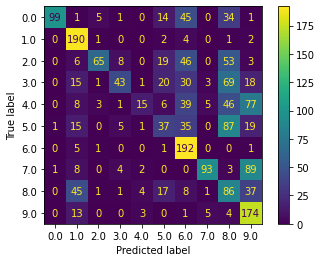

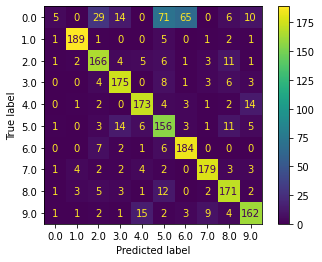

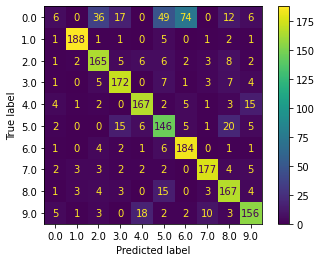

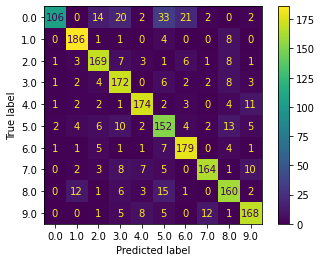

In [ ]:
#Training and Testing
if model_name == "NaiveBayes":
  gaussianNB = GaussianNB()
  gaussianNB_pca = GaussianNB()
  gaussianNB_kpca = GaussianNB()
  gaussianNB_lda = GaussianNB()
  evaluate2(gaussianNB, x_train_aug, y_train_label_aug, x_test, y_test_label, "Naive Bayes Gaussian")
  #PCA
  evaluate2(gaussianNB_pca, x_train_aug_pca, y_train_label_aug, pca_digits.transform(x_test), y_test_label, "Naive Bayes Gaussian+PCA")
  #kPCA
  evaluate2(gaussianNB_kpca, x_train_aug_kpca, y_train_label_aug, kpca_digits.transform(x_test), y_test_label, "Naive Bayes Gaussian+kPCA")
  #LDA
  evaluate2(gaussianNB_lda, x_train_aug_lda, y_train_label_aug, lda_digits.transform(x_test), y_test_label, "Naive Bayes Gaussian+LDA")


### CNN 

**For validation results of CNN and CNN Ensemble, please refer to** https://colab.research.google.com/drive/1ypxLWrY5ud0hjbWZMxqgUY3tNsf-pwYP?usp=sharing

In [ ]:
def M3(img_size = 36):
    keras.backend.clear_session() # clear previous cache
    model = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                    layers.Resizing(img_size, img_size), 
                                    keras.layers.Conv2D(filters=16, kernel_size=(3,3), 
                                                          padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=80, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=112, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=144, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=160, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=176, kernel_size=(3, 3), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Flatten(),# flatten layer 
                                    keras.layers.Dense(units = 256,activation='relu'),  #input layer 
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dense(units = 10, activation='softmax'),# output layer 
    ])
    return model
def M5(img_size = 36):
    keras.backend.clear_session() # clear previous cache
    model = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                    layers.Resizing(img_size, img_size), 
                                      keras.layers.Conv2D(filters=16, kernel_size=(5,5), 
                                                          padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=96, kernel_size=(5, 5), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=160, kernel_size=(5, 5), padding='valid', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Flatten(),# flatten layer 
                                    keras.layers.Dense(units = 256, activation='relu'),  #input layer 
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dense(units = 10, activation='softmax'),# output layer 
    ])
    return model
def M7(img_size = 36):
    keras.backend.clear_session() # clear previous cache
    model = keras.models.Sequential([
                                keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                layers.Resizing(img_size, img_size), # Effect of resize : https://keras.io/examples/vision/learnable_resizer/
                                keras.layers.Conv2D(filters=48, kernel_size=(7, 7), 
                                                    # input_shape=(IMG_SIZE,IMG_SIZE,1),
                                                    padding='valid', activation="relu"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(filters=96, kernel_size=(7, 7), padding='valid', activation="relu"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(filters=144, kernel_size=(7, 7), padding='valid', activation="relu"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv2D(filters=192, kernel_size=(7, 7), padding='valid', activation="relu"),
                                keras.layers.BatchNormalization(),
                                keras.layers.Flatten(),# flatten layer 
                                keras.layers.Dense(units = 128, activation='relu'),  #input layer 
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(units = 10, activation='softmax'),# output layer 
    ])
    return model

In [ ]:
if model_name == "CNN":
    # Parameters Setting
    batch_size = 64 # 32, 128, 256 
    max_epochs = 5
    img_size = 36
    cnn_aug = False # Use extra augmentation 
    if cnn_aug:
        x_train_vl = x_train_aug.copy()
    else:
        x_train_vl = x_train.values    
    normalize = True
    if x_train_vl.max() == 1.0:
        x_train_vl = x_train_vl * 255
    if normalize:
        x_train_vl = x_train_vl / 255.0
        
    x_train_vl = x_train_vl.astype(float)
    x_train_ts = x_train_vl.reshape(x_train_vl.shape[0], 28, 28, 1)
    
    x_test_vl = x_test.values
    if x_test_vl.max() == 1.0:
        x_test_vl = x_test_vl * 255
    if normalize:
        x_test_vl = x_test_vl / 255.0
    x_test_vl = x_test_vl.astype(float)
    x_test_ts = x_test_vl.reshape(x_test_vl.shape[0], 28, 28, 1)
    
    if cnn_aug:
        y_train_encoded = keras.utils.to_categorical(y_train_label_aug, num_classes)
        train_x, validation_x, train_y, validation_y = train_test_split(x_train_ts, y_train_encoded, test_size = 0.1, random_state = SEED)
    else:
        train_x, validation_x, train_y, validation_y = train_test_split(x_train_ts, y_train, test_size = 0.1, random_state = SEED)

    if  not cnn_aug:
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                # zca_whitening=True,  # apply ZCA whitening
                rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                # zoom_range = [0.7, 1], # Randomly zoom image 
                # zoom_range = 0.01, # Randomly zoom image 
                zoom_range = 0.3, # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=False,  # randomly flip images
                vertical_flip=False # randomly flip images
            )  
            train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)
            val_gen = datagen.flow(validation_x, validation_y, batch_size=batch_size)

    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    my_callbacks = [
        # tf.keras.callbacks.LearningRateScheduler(scheduler),
        tf.keras.callbacks.EarlyStopping(patience=25, monitor = "val_accuracy", mode = 'max'),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

    keras.backend.clear_session() # clear previous cache
    # Mode1 - model 3 not used in final report
    model1 = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                    layers.Resizing(img_size, img_size), 
                                    keras.layers.Conv2D(filters=16, kernel_size=(3,3), 
                                                        # input_shape=(28, 28, 1), 
                                                        padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Conv2D(filters=48, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Flatten(),# flatten layer 
                                    keras.layers.Dense(units = 128,activation='relu'),  #input layer 
                                    keras.layers.Dense(units = 64, activation='relu'),  # hidden layer 
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(units = 10, activation='softmax'),# output layer 
                        ])
    model2 = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                    layers.Resizing(img_size, img_size), 
                                    keras.layers.Conv2D(filters=32, kernel_size=(3,3), 
                                                        # input_shape=(28, 28, 1), 
                                                        padding='same', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.BatchNormalization(),
                                    # keras.layers.Dropout(0.2),
                                    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.BatchNormalization(),  
                                    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.BatchNormalization(),
                                    # keras.layers.Dropout(0.2),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.BatchNormalization(),
                                    # keras.layers.Dropout(0.2),
                                    keras.layers.Flatten(),# flatten layer 
                                    keras.layers.Dense(units = 256,activation='relu'),  #input layer 
                                    # keras.layers.Dense(units = 64, activation='relu'),  # hidden layer 
                                    keras.layers.BatchNormalization(),
                                    # keras.layers.Dropout(0.2),
                                    keras.layers.Dense(units = 10, activation='softmax'),# output layer 
                        ])
    model3 = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                    layers.Resizing(img_size, img_size), 
                                    keras.layers.Conv2D(filters=32, kernel_size=(3,3), 
                                                        # input_shape=(28, 28, 1), 
                                                        padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"),
                                    # keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    # keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    # keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    # keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation="relu"),
                                    # keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation="relu"),
                                    # keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"),
                                    keras.layers.MaxPooling2D(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Flatten(),# flatten layer 
                                    keras.layers.Dense(units = 256,activation='relu'),  
                                    # keras.layers.Dense(units = 64, activation='relu'),  
                                    keras.layers.Dropout(0.2),
                                    # kernel_regularizer=l2(0.01)
                                    keras.layers.Dense(units = 10, activation='softmax'),# output layer 
                        ])
    model4 = M3()
    model5 = M5()
    model6 = M7()
    ensemble_flag = True
    rms = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9, epsilon=0.1)
    sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    adam = keras.optimizers.Adam(learning_rate=0.001, decay = 1e-6)
    
    names = ["M3", "M5", "M7"]
    checkpoint_path = 'tmp/checkpoint'
    if ensemble_flag:
        models = [model4, model5, model6]
        for i in range(len(models)):
            keras.backend.clear_session()
            opt_ensemble = rms
            best_model_str = names[i] + ".h5"
            new_callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=25, monitor = "val_accuracy", mode = 'max'),
                tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', verbose=0, save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir='./logs'),
            ]
            if names[i] == 'M7':
                opt_ensemble = adam
            models[i].compile(
                loss="categorical_crossentropy",
                optimizer=opt_ensemble,
                # optimizer = 'adam',
                metrics=["accuracy"]
            )
            print("### Start Training " + names[i])
            train_steps = train_x.shape[0] // batch_size
            valid_steps = validation_x.shape[0] // batch_size
            history = models[i].fit_generator(train_gen, 
                        epochs = max_epochs, 
                        verbose = 1,
                        steps_per_epoch = train_steps,
                        validation_data = val_gen,
                        validation_steps = valid_steps, 
                    callbacks=new_callbacks)
            models[i] = load_model(checkpoint_path)
            print("======================================")
            print("### Test Result: ")
            models[i].evaluate(x_test_ts, y_test)
    else:
        model = model5
        model.compile(
            loss="categorical_crossentropy",
            optimizer=rms,
            # optimizer = 'adam',
            metrics=["accuracy"]
        )
        print("### Start Training")
        # model.build(train_x.shape)
        # model.summary() 
        if cnn_aug:
            history = model.fit(
                train_x, train_y, batch_size = batch_size, epochs = max_epochs, verbose = 1,
                validation_data = (validation_x, validation_y),
                callbacks = my_callbacks
                )
        else:
            train_steps = train_x.shape[0] // batch_size
            valid_steps = validation_x.shape[0] // batch_size
            history = model.fit_generator(train_gen, 
                        epochs = max_epochs, 
                        verbose = 1,
                        steps_per_epoch = train_steps,
                        validation_data = val_gen,
                        validation_steps = valid_steps, 
                        callbacks=my_callbacks)
        # plot training history
        model.summary()
        model = load_model('best_model.h5')
    
        pd.DataFrame(history.history).plot()
        print("======================================")
        print("### Test Result: ")
        model.evaluate(x_test_ts, y_test)

In [ ]:
    # Optimizer
    #   ema = tf.train.ExponentialMovingAverage(decay=0.50,name='EMA')
    #       total_steps = int((len(x_train_vl) / batch_size) * num_epochs)
    #   warmup_epoch_percentage = 0.10
    #   warmup_steps = int(total_steps * warmup_epoch_percentage)
    #   scheduled_lrs = WarmUpCosine(
    #       learning_rate_base=learning_rate,
    #       total_steps=total_steps,
    #       warmup_learning_rate=0.0,
    #       warmup_steps=warmup_steps,
    #   )
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )


    # plt.plot(history.history['accuracy'], label='train')
    # plt.plot(history.history['val_accuracy'], label='validation')
    # plt.legend()
    # plt.show()

In [ ]:
# print("My Custom CNN Network:")
# plot_model(model_cnn(), to_file='custom-cnn.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Evaluate ensemble models with hard voting or soft voting 
def voting_evaluate(soft_voting, input, target, models, names):
    if soft_voting:
        probs = np.zeros((len(y_test), 10), dtype= float)
        for i in range(len(models)):
            print("Model: " + names[i])
            probs = probs + models[i].predict(input)
            models[i].evaluate(input, target)
        y_voting = probs.argmax(axis = 1)
    else:
        # Predict labels with models
        labels = []
        for i in range(len(models)):
            print("Model: " + names[i])
            y_pred = np.argmax(models[i].predict(input), axis=1)
            models[i].evaluate(input, target)
            labels.append(y_pred)
        # Ensemble with hard voting
        labels = np.array(labels)
        labels = np.transpose(labels)
        y_voting = np.zeros(labels.shape[0])
        for i in range(len(y_voting)):
            vals,counts = np.unique(labels[i], return_counts=True)
            index = np.argmax(counts)
            if counts[index] == 1:
                y_voting[i] = labels[i][np.random.choice(range(labels[i].shape[0]))] # randomly takes one if the three models vote on different class,
            else:
                y_voting[i] = vals[index]
    # Output results
    print("Accuracy: %.4f" % accuracy_score(y_voting, target.argmax(axis = 1)))
    return y_voting

In [ ]:
voting_evaluate(False, x_test_ts, y_test, models, names)

Model: M3
63/63 [==============================] - 1s 9ms/step - loss: 1.2806 - accuracy: 0.5795
Model: M5
63/63 [==============================] - 0s 6ms/step - loss: 1.6731 - accuracy: 0.4450
Model: M7
63/63 [==============================] - 1s 8ms/step - loss: 7.6169 - accuracy: 0.1910
Accuracy: 0.4485


array([0., 0., 6., ..., 8., 8., 8.])

### Vision Transformer
<br /> Modified from: https://keras.io/examples/vision/image_classification_with_vision_transformer/

Result: 
Epoch = 20, Accu: % <br/>

Epoch = , Accu: 

In [ ]:
if model_name == "ViT":
  ### Setting parameters 
  learning_rate = 0.001
  weight_decay = 0.0001
  batch_size = 32 # Remain to be changed 
  num_epochs = 20
  input_size = 28
  image_size = 72  # We'll resize input images to this size
  patch_size = 6  # Size of the patches to be extract from the input images
  num_patches = (image_size // patch_size) ** 2
  projection_dim = 64
  num_heads = 4
  transformer_units = [
      projection_dim * 2,
      projection_dim,
  ]  # Size of the transformer layers
  transformer_layers = 8
  mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
  input_shape = [input_size, input_size, 1]

  ### Data augmentation 
  vit_data_augmentation = keras.Sequential(
    [
        keras.layers.Input(input_shape),
        layers.Rescaling(1./255.0),
        layers.Normalization(), 
        # layers.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.RandomRotation(factor=0.02), # minor improvement, 0.86 -> 0.88(only for dataset 1)
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2 # Minor improvement for dataset 0
        ),
    ],
    name="data_augmentation",
  )
  ### Implement the multilayer perceptron 
  def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
  #### Implement patch creation as a layer 
  class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

  # Training set
  x_train_vl = x_train.values
  x_train_vl = x_train_vl.reshape(x_train_vl.shape[0], 28, 28, 1)

  ind_list = [list(range(x_train_vl.shape[0]))]
  shuffle(ind_list)
  x_train_shuffle  =x_train_vl[ind_list, :,:,:]
  y_train = y_train.values[ind_list,]
  # Test set 
  x_test_vl = x_test.values
  x_test_vl = x_test_vl.reshape(x_test_vl.shape[0], 28, 28, 1)
  ### Inspect on the patched image
  plt.figure(figsize=(4, 4))
  image = x_train_vl[np.random.choice(range(x_train_vl.shape[0]))]
  image = image.reshape(28, 28, 1)
  plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
  plt.axis("off")

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size=(image_size, image_size)
  )
  patches = Patches(patch_size)(resized_image)
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  print(f"Patches per image: {patches.shape[1]}")
  print(f"Elements per patch: {patches.shape[-1]}")

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))
  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
      plt.imshow(patch_img.numpy()[:,:,0].astype("uint8"), cmap = 'gray')
      plt.axis("off")
  """
  ## Implement the patch encoding layer

  The `PatchEncoder` layer will linearly transform a patch by projecting it into a
  vector of size `projection_dim`. In addition, it adds a learnable position
  embedding to the projected vector.
  """
  class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


#### Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = vit_data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


#### Compile, train, and evaluate the mode

In [ ]:
if model_name == "ViT":
  keras.backend.clear_session()
  vit_classifier = create_vit_classifier()
  # vit_classifier.summary()

In [ ]:

def run_vit_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True), ### ???? change to CategoricalCrossentropy
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_filepath = "model.5h"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    train_x, validation_x, train_y, validation_y = train_test_split(x_train_vl, y_train, test_size = 0.1, random_state = SEED)
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        epochs=num_epochs,
        # validation_split = 0.1,
        validation_data = (validation_x, validation_y),
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test_vl, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history

if model_name == "ViT":
  vit_classifier = create_vit_classifier()
  model, history = run_vit_experiment(vit_classifier)


After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

### Vision Transformer for small-size data set
<br /> Modified from: https://keras.io/examples/vision/image_classification_with_vision_transformer/
https://keras.io/examples/vision/vit_small_ds/



Result: 
Epoch = 50, Batch size = 64, Accu: 95%, 78% on  challenge test <br/>

Epoch = , Accu: 

In [ ]:
if model_name == "ViT_SPT":
  ### Setting parameters 
  # Data 
  buffer_size = 512
  batch_size = 64 # Remain to be changed 
  input_size = 28
  input_shape = [input_size, input_size, 1]


  # Augmentation 
  image_size = 72  # We'll resize input images to this size
  patch_size = 6  # Size of the patches to be extract from the input images
  num_patches = (image_size // patch_size) ** 2

  # Optimizer 
  learning_rate = 0.001
  weight_decay = 0.0001

  ## Training
  num_epochs = 50

  # Architecture
  layer_norm_eps = 1e-6
  projection_dim = 64
  num_heads = 4
  transformer_units = [
      projection_dim * 2,
      projection_dim,
  ]  # Size of the transformer layers
  transformer_layers = 8
  mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
if model_name == "ViT_SPT":
   ### Data augmentation 
  vit_spt_data_augmentation = keras.Sequential(
    [
        keras.layers.Input(input_shape),
        layers.Rescaling(1./255.0),
        layers.Normalization(), 
        layers.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.RandomRotation(factor=0.02), # minor improvement, 0.86 -> 0.88(only for dataset 1)
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2 # Minor improvement for dataset 0
        ),
    ],
    name="data_augmentation",
  )

  # Compute the mean and the variance of the training data for normalization.
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
  # data_augmentation.layers[0].adapt(x_train)

#### Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [ ]:
if model_name == "ViT_SPT":
  class ShiftedPatchTokenization(layers.Layer):
      def __init__(
          self,
          image_size= image_size,
          patch_size= patch_size,
          num_patches= num_patches,
          projection_dim= projection_dim,
          vanilla=False,
          **kwargs,
      ):
          super().__init__(**kwargs)
          self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
          self.image_size = image_size
          self.patch_size = patch_size
          self.half_patch = patch_size // 2
          self.flatten_patches = layers.Reshape((num_patches, -1))
          self.projection = layers.Dense(units=projection_dim)
          self.layer_norm = layers.LayerNormalization(epsilon=layer_norm_eps)

      def crop_shift_pad(self, images, mode):
          # Build the diagonally shifted images
          if mode == "left-up":
              crop_height = self.half_patch
              crop_width = self.half_patch
              shift_height = 0
              shift_width = 0
          elif mode == "left-down":
              crop_height = 0
              crop_width = self.half_patch
              shift_height = self.half_patch
              shift_width = 0
          elif mode == "right-up":
              crop_height = self.half_patch
              crop_width = 0
              shift_height = 0
              shift_width = self.half_patch
          else:
              crop_height = 0
              crop_width = 0
              shift_height = self.half_patch
              shift_width = self.half_patch

          # Crop the shifted images and pad them
          crop = tf.image.crop_to_bounding_box(
              images,
              offset_height=crop_height,
              offset_width=crop_width,
              target_height=self.image_size - self.half_patch,
              target_width=self.image_size - self.half_patch,
          )
          shift_pad = tf.image.pad_to_bounding_box(
              crop,
              offset_height=shift_height,
              offset_width=shift_width,
              target_height=self.image_size,
              target_width=self.image_size,
          )
          return shift_pad

      def call(self, images):
          if not self.vanilla:
              # Concat the shifted images with the original image
              images = tf.concat(
                  [
                      images,
                      self.crop_shift_pad(images, mode="left-up"),
                      self.crop_shift_pad(images, mode="left-down"),
                      self.crop_shift_pad(images, mode="right-up"),
                      self.crop_shift_pad(images, mode="right-down"),
                  ],
                  axis=-1,
              )
          # Patchify the images and flatten it
          patches = tf.image.extract_patches(
              images=images,
              sizes=[1, self.patch_size, self.patch_size, 1],
              strides=[1, self.patch_size, self.patch_size, 1],
              rates=[1, 1, 1, 1],
              padding="VALID",
          )
          flat_patches = self.flatten_patches(patches)
          if not self.vanilla:
              # Layer normalize the flat patches and linearly project it
              tokens = self.layer_norm(flat_patches)
              tokens = self.projection(tokens)
          else:
              # Linearly project the flat patches
              tokens = self.projection(flat_patches)
          return (tokens, patches)


In [ ]:
if model_name == "ViT_SPT":  
  """
  ## Implement the patch encoding layer

  This layer accepts projected patches and then adds positional
  information to them.
  """
  # class PatchEncoder(layers.Layer):
  #   def __init__(self, num_patches, projection_dim):
  #       super(PatchEncoder, self).__init__()
  #       self.num_patches = num_patches
  #       self.projection = layers.Dense(units=projection_dim)
  #       self.position_embedding = layers.Embedding(
  #           input_dim=num_patches, output_dim=projection_dim
  #       )

  #   def call(self, patch):
  #       positions = tf.range(start=0, limit=self.num_patches, delta=1)
  #       encoded = self.projection(patch) + self.position_embedding(positions)
  #       return encoded
  class PatchEncoder(layers.Layer):
      def __init__(
          self, num_patches=num_patches, 
          projection_dim= projection_dim, **kwargs
      ):
          super().__init__(**kwargs)
          self.num_patches = num_patches
          self.position_embedding = layers.Embedding(
              input_dim=num_patches, output_dim=projection_dim
          )
          self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

      def call(self, encoded_patches):
          encoded_patches = encoded_patches + self.position_embedding(self.positions)
          return encoded_patches

In [ ]:
if model_name == "ViT_SPT":
  # x_train_vl = x_train.values
  # x_train_vl = x_train_vl.reshape(x_train_vl.shape[0], 28, 28, 1)

  # x_test_vl = x_test.values
  # x_test_vl = x_test_vl.reshape(x_test_vl.shape[0], 28, 28, 1)

  x_train_vl = x_train_aug.copy()
  x_train_vl = x_train_vl.reshape(x_train_vl.shape[0], 28, 28, 1)

  x_test_vl = x_test.values
  x_test_vl = x_test_vl.reshape(x_test_vl.shape[0], 28, 28, 1)

#### Visualize the patches

In [ ]:
if model_name == "ViT_SPT":
  # Get a random image from the training dataset
  # and resize the image
  plt.figure(figsize=(4, 4))
  image = x_train_vl[np.random.choice(range(x_train_vl.shape[0]))]
  image = image.reshape(28, 28, 1)
  plt.imshow(image[:,:,0].astype("uint8"), cmap = 'gray')
  plt.axis("off")

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size=(image_size, image_size)
  )

  # Vanilla patch maker: This takes an image and divides into 
  # patches as in the original ViT paper
  (token, patch) = ShiftedPatchTokenization(vanilla = True)(resized_image / 255.0)
  (token, patch) = (token[0], patch[0])
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  # print(f"Patches per image: {patch.shape[1]}")
  # print(f"Elements per patch: {patch.shape[-1]}")
  n = patch.shape[0]
  count = 1
  plt.figure(figsize=(4, 4))
  for row in range(n):
      for col in range(n):
          plt.subplot(n, n, count)
          count = count + 1
          image = tf.reshape(patch[row][col], (patch_size, patch_size, 1))
          plt.imshow(image.numpy()[:,:,0], cmap= 'gray')
          plt.axis("off")
  plt.show()

  # Shifted Patch Tokenization: This layer takes the image, shifts it
  # diagonally and then extracts patches from the concatinated images
  print("Shifting Patch Image")
  (token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
  (token, patch) = (token[0], patch[0])
  n = patch.shape[0]
  shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
  for index, name in enumerate(shifted_images):
      print(name)
      count = 1
      plt.figure(figsize=(4, 4))
      for row in range(n):
          for col in range(n):
              plt.subplot(n, n, count)
              count = count + 1
              image = tf.reshape(patch[row][col], (patch_size, patch_size, 5 * 1))
              plt.imshow(image[..., index : index + 1].numpy()[:,:,0], cmap = 'gray')
              plt.axis("off")
      plt.show()

  # patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
  # plt.imshow(patch_img.numpy()[:,:,0].astype("uint8"), cmap = 'gray')

#### Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [ ]:
if model_name == "ViT_SPT":
  class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
      def __init__(self, **kwargs):
          super().__init__(**kwargs)
          # The trainable temperature term. The initial value is
          # the square root of the key dimension.
          self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

      def _compute_attention(self, query, key, value, attention_mask=None, training=None):
          query = tf.multiply(query, 1.0 / self.tau)
          attention_scores = tf.einsum(self._dot_product_equation, key, query)
          attention_scores = self._masked_softmax(attention_scores, attention_mask)
          attention_scores_dropout = self._dropout_layer(
              attention_scores, training=training
          )
          attention_output = tf.einsum(
              self._combine_equation, attention_scores_dropout, value
          )
          return attention_output, attention_scores


In [ ]:
if model_name == "ViT_SPT":
  # Build the diagonal attention mask
  diag_attn_mask = 1 - tf.eye(num_patches)
  diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
if model_name == "ViT_SPT":
  ### Implement the multilayer perceptron 
  def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
if model_name == "ViT_SPT":  
    def create_vit_spt_classifier(vanilla = False):
      inputs = layers.Input(shape=input_shape)
      # Augment data.
      augmented = vit_spt_data_augmentation(inputs)
      # Create patches.
      (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
      # Encode patches.
      encoded_patches = PatchEncoder()(tokens)

      # Create multiple layers of the Transformer block.
      for _ in range(transformer_layers):
          # Layer normalization 1.
          x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
          # Create a multi-head attention layer.
          if not vanilla:
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1, attention_mask = diag_attn_mask)
          else:
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
          # Skip connection 1.
          x2 = layers.Add()([attention_output, encoded_patches])
          # Layer normalization 2.
          x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
          # MLP.
          x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
          # Skip connection 2.
          encoded_patches = layers.Add()([x3, x2])

      # Create a [batch_size, projection_dim] tensor.
      representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      representation = layers.Flatten()(representation)
      representation = layers.Dropout(0.5)(representation)
      # Add MLP.
      features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
      # Classify outputs.
      logits = layers.Dense(num_classes)(features)
      # Create the Keras model.
      model = keras.Model(inputs=inputs, outputs=logits)
      return model

In [ ]:
if model_name == "ViT_SPT":
  # Some code is taken from: ???
  # https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
  class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
      def __init__(
          self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
      ):
          super(WarmUpCosine, self).__init__()

          self.learning_rate_base = learning_rate_base
          self.total_steps = total_steps
          self.warmup_learning_rate = warmup_learning_rate
          self.warmup_steps = warmup_steps
          self.pi = tf.constant(np.pi)

      def __call__(self, step):
          if self.total_steps < self.warmup_steps:
              raise ValueError("Total_steps must be larger or equal to warmup_steps.")

          cos_annealed_lr = tf.cos(
              self.pi
              * (tf.cast(step, tf.float32) - self.warmup_steps)
              / float(self.total_steps - self.warmup_steps)
          )
          learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

          if self.warmup_steps > 0:
              if self.learning_rate_base < self.warmup_learning_rate:
                  raise ValueError(
                      "Learning_rate_base must be larger or equal to "
                      "warmup_learning_rate."
                  )
              slope = (
                  self.learning_rate_base - self.warmup_learning_rate
              ) / self.warmup_steps
              warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
              learning_rate = tf.where(
                  step < self.warmup_steps, warmup_rate, learning_rate
              )
          return tf.where(
              step > self.total_steps, 0.0, learning_rate, name="learning_rate"
          )

In [ ]:
if model_name == "ViT_SPT":
  def run_vit_spt_experiment(model):
      total_steps = int((len(x_train_vl) / batch_size) * num_epochs)
      warmup_epoch_percentage = 0.10
      warmup_steps = int(total_steps * warmup_epoch_percentage)
      scheduled_lrs = WarmUpCosine(
          learning_rate_base=learning_rate,
          total_steps=total_steps,
          warmup_learning_rate=0.0,
          warmup_steps=warmup_steps,
      )
      optimizer = tfa.optimizers.AdamW(
          learning_rate=learning_rate, weight_decay=weight_decay
      )

      model.compile(
          optimizer=optimizer,
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), ### ???? change to CategoricalCrossentropy
          metrics=[
              keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
              keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
          ],
      )
      # y_train_encoded = keras.utils.to_categorical(y_train_label_aug, num_classes)
  # y_test = keras.utils.to_categorical(y_test, num_classes)
      train_x, validation_x, train_y, validation_y = train_test_split(x_train_vl, 
                                                                      y_train_label_aug,
                                                                      # y_train, 
                                                                      test_size = 0.1, random_state = SEED)
      history = model.fit(
          x= train_x,
          y= train_y,
          batch_size=batch_size,
          epochs=num_epochs,
          # validation_split = 0.1,
          shuffle= True,
          validation_data = (validation_x, validation_y),
      )

      _, accuracy, top_5_accuracy = model.evaluate(x_test_vl, y_test_label, batch_size = batch_size)
      print(f"Test accuracy: {round(accuracy * 100, 2)}%")
      print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

      return model, history

In [ ]:
if model_name == "ViT_SPT":
  keras.backend.clear_session()

  # Run experiments with the vanilla ViT
  vit = create_vit_spt_classifier(vanilla=True)
  model1, history = run_vit_spt_experiment(vit)

  # Run experiments with the Shifted Patch Tokenization and
  # Locality Self Attention modified ViT
  vit_sl = create_vit_spt_classifier(vanilla=False)
  model2, history = run_vit_spt_experiment(vit_sl)

  # vit_classifier = create_vit_classifier()
  # # vit_classifier.summary()
  # model, history = run_vit_experiment(vit_classifier)

#### Compile, train, and evaluate the mode

#### Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

### About batch size

In [ ]:
# Batch size

"""
Batch Gradient Descent. Batch Size = Size of Training Set
Stochastic Gradient Descent. Batch Size = 1
Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

"""

## Challenge Test

### Import challenge dataset

In [ ]:
# Import data 
croot_path = "https://raw.githubusercontent.com/William-WANG2/CS5487-CityU/master/dataset/challenge/" # path where we put data
clabel_url = os.path.join(croot_path, "cdigits_digits_labels.txt")
cdata_url = os.path.join(croot_path, "cdigits_digits_vec.txt")



In [ ]:
clabel = pd.read_csv(clabel_url, sep = ' ', header = None)
clabel.columns = ['label']
cdata = pd.read_csv(cdata_url, sep = '\t', header = None)


In [ ]:
print(clabel.shape)
print(cdata.shape)
print(x_test.shape)
print(y_test.shape)

(150, 1)
(150, 784)
(2000, 784)
(2000, 10)


In [ ]:
clabel_arr = clabel

###Extract feature from the data 

In [ ]:
extract_flag = False
extract_feature = "avg2"
if extract_flag and extract_feature == "avg2":
  # We choose to average the 2*2 pixels' values and assign it to a new one.
  cdata_ori = cdata.to_numpy()
  cdata = np.zeros([150, 196])
  for num in range(150):
    idx = 0
    for i in range(0, 28, 2):
      for j in range(0, 28, 2):
        cdata[num, idx] = (cdata_ori[num, i*28+j]+cdata_ori[num, i*28+j+1]+cdata_ori[num, (i+1)*28+j]+cdata_ori[num, (i+1)*28+j+1])/4
        idx += 1

### Testing

### Challenge Result: 
CNN
1.0
Model: M3
5/5 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.9533
Model: M5
5/5 [==============================] - 0s 7ms/step - loss: 0.2523 - accuracy: 0.9400
Model: M7
5/5 [==============================] - 0s 7ms/step - loss: 0.2488 - accuracy: 0.9533
Accuracy: 0.9600


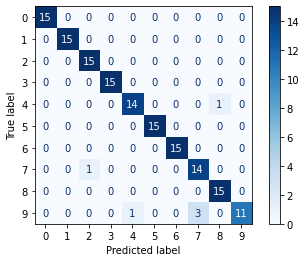

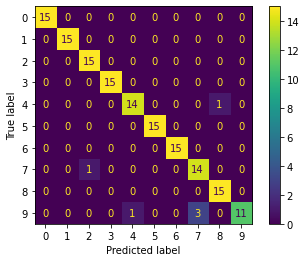

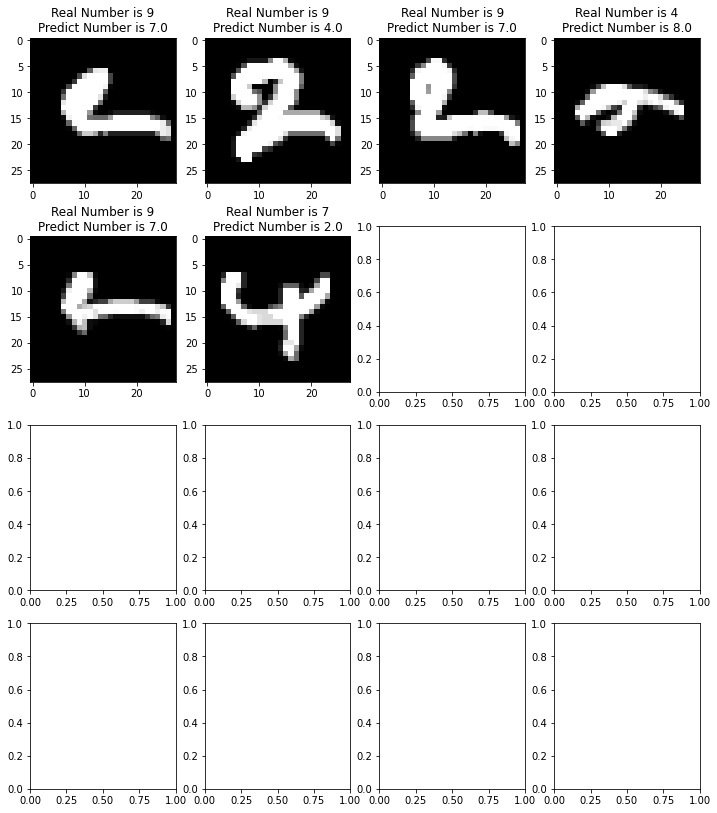

In [ ]:
print("======================================")
print("### Challenge Result: ")

if  model_name == 'SVM':
    #normalization
    cdata = cdata/255
    pred = lsvm_pca.predict(pca_digits.transform(cdata))
    print("======================================")
    print("### Challenge Result SVM+PCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = ksvm_pca.predict(pca_digits.transform(cdata))
    print("### Challenge Result kSVM+PCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = lsvm_kpca.predict(kpca_digits.transform(cdata))
    print("### Challenge Result SVM+kPCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = ksvm_kpca.predict(kpca_digits.transform(cdata))
    print("### Challenge Result kSVM+kPCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = lsvm_lda.predict(lda_digits.transform(cdata))
    print("### Challenge Result SVM+LDA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = ksvm_lda.predict(lda_digits.transform(cdata))
    print("### Challenge Result kSVM+LDA: ")
    print(accuracy_score(pred, clabel_arr))
elif  model_name == 'MLP':
    print("Simple Neural Network")
    x_challenge = cdata
    y_challenge = keras.utils.to_categorical(clabel, num_classes)
    model.evaluate(x_challenge, y_challenge)
elif model_name == "CNN":
    print("CNN")
    cdata_vl = cdata.values.astype(float)
    if cdata_vl.max() == 1:
        cdata_vl = cdata_vl * 255
    if normalize:
        cdata_vl = cdata_vl/255.0

    x_challenge = tf.reshape(cdata_vl, (cdata_vl.shape[0], 28, 28, 1))
    y_challenge = keras.utils.to_categorical(clabel, num_classes)

    y_pred = voting_evaluate(True, x_test_ts, y_test, models, names)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_challenge.argmax(axis = 1),
        y_pred,
        cmap = "Blues",
    )
    disp.plot()
    # Plot mis-classified samples

    fig, axis = plt.subplots(4, 4, figsize=(12, 14))
    row = 0
    col = 0
    for j in range(x_challenge.shape[0]):
        if y_pred[j] == y_challenge[j].argmax():
            continue
        image = x_challenge[j]
        axis[row, col].imshow(image[:,:,0], cmap = 'gray')
        axis[row, col].set(title = f"Real Number is {y_challenge[j].argmax()}\nPredict Number is {y_pred[j]}");
        col+=1
        if col >= 4: 
            col = col % 4
            row+=1
elif model_name == 'ViT':
    print("Vision Transformer")
    x_challenge =  tf.reshape(cdata, (cdata.shape[0], 28, 28, 1))
    y_challenge = clabel
    model.evaluate(x_challenge, y_challenge)
elif model_name == "ViT_SPT":
    print("Vision Transformer with SPT")
    x_challenge =  tf.reshape(cdata, (cdata.shape[0], 28, 28, 1))
    y_challenge = clabel
    print("With vanilla ViT")
    model1.evaluate(x_challenge, y_challenge)
    print("With SPT & LSA ViT")
    model2.evaluate(x_challenge, y_challenge)
elif model_name == 'Logit':
    cdata = cdata/255
    pred = logit.predict(cdata)
    print("======================================")
    print("### Challenge Result Logistic Regression: ")
    print(accuracy_score(pred, clabel_arr))
    pred = logit_pca.predict(pca_digits.transform(cdata))
    print("### Challenge Result Logistic Regression+PCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = logit_kpca.predict(kpca_digits.transform(cdata))
    print("### Challenge Result Logistic Regression+kPCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = logit_lda.predict(lda_digits.transform(cdata))
    print("### Challenge Result Logistic Regression+LDA: ")
    print(accuracy_score(pred, clabel_arr))
elif model_name == 'NaiveBayes':
    cdata = cdata/255
    pred = gaussianNB.predict(cdata)
    print("======================================")
    print("### Challenge Result Naive Bayes: ")
    print(accuracy_score(pred, clabel_arr))
    pred = gaussianNB_pca.predict(pca_digits.transform(cdata))
    print("### Challenge Result Naive Bayes+PCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = gaussianNB_kpca.predict(kpca_digits.transform(cdata))
    print("### Challenge Result Naive Bayes+kPCA: ")
    print(accuracy_score(pred, clabel_arr))
    pred = gaussianNB_lda.predict(lda_digits.transform(cdata))
    print("### Challenge Result Naive Bayes+LDA: ")
    print(accuracy_score(pred, clabel_arr))